In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from pathlib import Path

BASE = Path("/content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object")
IMG_DIR = BASE / "data_object_image_2" / "training" / "image_2"
LBL_DIR = BASE / "data_object_label_2" / "training" / "label_2"

assert IMG_DIR.exists(), IMG_DIR
assert LBL_DIR.exists(), LBL_DIR

imgs_all = sorted(IMG_DIR.glob("*.png"))
print("Total train images:", len(imgs_all))

START = 0
N = 500
selected = imgs_all[START:START+N]
print(f"Selected batch: START={START}, N={N}, actual={len(selected)}")
print("First/last:", selected[0].name if selected else None, "->", selected[-1].name if selected else None)


Mounted at /content/drive
Total train images: 7497
Selected batch: START=0, N=500, actual=500
First/last: 000000.png -> 000499.png


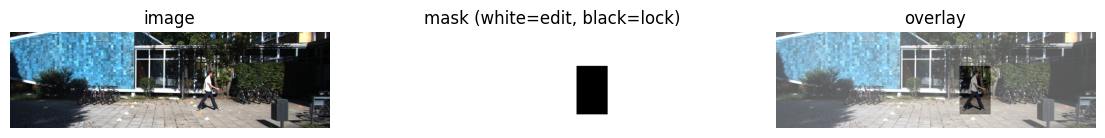

Image: 000000.png Boxes: 1


In [27]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def parse_kitti_boxes(lbl_path: Path):
    boxes = []
    if not lbl_path.exists():
        return boxes
    for line in lbl_path.read_text().splitlines():
        if not line.strip():
            continue
        parts = line.split()
        if parts[0] == "DontCare":
            continue
        left, top, right, bottom = map(float, parts[4:8])
        if right > left and bottom > top:
            boxes.append((left, top, right, bottom))
    return boxes

PAD = 10

img_path = selected[0]
lbl_path = LBL_DIR / (img_path.stem + ".txt")

img = Image.open(img_path).convert("RGB")
W, H = img.size

mask = Image.new("L", (W, H), 255)
draw = ImageDraw.Draw(mask)

for (l,t,r,b) in parse_kitti_boxes(lbl_path):
    l = max(0, int(l - PAD)); t = max(0, int(t - PAD))
    r = min(W-1, int(r + PAD)); b = min(H-1, int(b + PAD))
    draw.rectangle([l,t,r,b], fill=0)

overlay = Image.blend(img, Image.merge("RGB",(mask,mask,mask)), alpha=0.35)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.title("image"); plt.imshow(img); plt.axis("off")
plt.subplot(1,3,2); plt.title("mask (white=edit, black=lock)"); plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("overlay"); plt.imshow(overlay); plt.axis("off")
plt.show()

print("Image:", img_path.name, "Boxes:", len(parse_kitti_boxes(lbl_path)))


In [28]:
!pip -q install -U diffusers transformers accelerate safetensors opencv-python

import torch, cv2, numpy as np
from PIL import Image, ImageDraw
from pathlib import Path
from diffusers import ControlNetModel, StableDiffusionXLControlNetInpaintPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

BASE_MODEL = "SG161222/RealVisXL_V4.0"
CONTROLNET = "diffusers/controlnet-canny-sdxl-1.0"

controlnet = ControlNetModel.from_pretrained(CONTROLNET, torch_dtype=dtype)

pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    torch_dtype=dtype,
    use_safetensors=True,
).to(device)

pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()


In [29]:
import torch, cv2, numpy as np
from PIL import Image
from diffusers import ControlNetModel, StableDiffusionXLControlNetInpaintPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

BASE_MODEL = "SG161222/RealVisXL_V4.0"
CONTROLNET = "diffusers/controlnet-canny-sdxl-1.0"

controlnet = ControlNetModel.from_pretrained(CONTROLNET, torch_dtype=dtype)

pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    torch_dtype=dtype,
    use_safetensors=True,
)

pipe.enable_model_cpu_offload()
pipe.enable_vae_slicing()
pipe.enable_vae_tiling()

try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception as e:
    print("xformers not enabled:", e)

print("Loaded OK")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

xformers not enabled: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
Loaded OK


/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/pipeline_utils.py:2186: FutureWarning: `enable_vae_slicing` is deprecated and will be removed in version 0.40.0. Calling `enable_vae_slicing()` on a `StableDiffusionXLControlNetInpaintPipeline` is deprecated and this method will be removed in a future version. Please use `pipe.vae.enable_slicing()`.
  deprecate(
/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/pipeline_utils.py:2213: FutureWarning: `enable_vae_tiling` is deprecated and will be removed in version 0.40.0. Calling `enable_vae_tiling()` on a `StableDiffusionXLControlNetInpaintPipeline` is deprecated and this method will be removed in a future version. Please use `pipe.vae.enable_tiling()`.
  deprecate(


In [30]:
def make_canny(img_pil: Image.Image, low=120, high=220):
    img = np.array(img_pil)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, low, high)
    edges_3c = np.stack([edges]*3, axis=-1)
    return Image.fromarray(edges_3c)

def save_pair(compare_dir: Path, img_path: Path, original_img: Image.Image, synthetic_img: Image.Image, tag=""):
    compare_dir.mkdir(parents=True, exist_ok=True)
    stem = img_path.stem
    ext = img_path.suffix
    orig_out = compare_dir / f"{stem}{ext}"
    suffix = f"_{tag}_S" if tag else "_S"
    synth_out = compare_dir / f"{stem}{suffix}{ext}"
    if not orig_out.exists():
        original_img.save(orig_out)
    synthetic_img.save(synth_out)


In [ ]:
from PIL import Image, ImageDraw
import torch

PROMPTS = {
    "snow": "same scene, same viewpoint, photorealistic dashcam photo, severe blizzard, dense falling snow, very large snowflakes close to camera, thick snowy haze, extremely low visibility, wet reflective asphalt, slush, winter storm",
    "rain": "same scene, same viewpoint, photorealistic dashcam photo, extreme heavy rainstorm, raindrops on windshield, water streaks, strong spray mist, wet glossy road reflections, stormy dark clouds, low visibility",
    "fog":  "same scene, same viewpoint, photorealistic dashcam photo, extremely thick fog, dense gray mist, heavy haze, very low visibility, diffused light, muted colors, foggy atmosphere"
}

NEG = (
    "scene change, different location, different road, different perspective, "
    "new objects, extra cars, duplicated vehicles, missing vehicles, "
    "warped road, deformed objects, distorted geometry, "
    "cartoon, anime, illustration, CGI, text, watermark, logo"
)

strength = 0.85
cfg = 7.5
steps = 30
PAD = 10
controlnet_scale = 0.6
feather=10

for weather in ["snow", "rain", "fog"]:
    OUT_DIR = BASE / "synth_controlnet" / weather / "images" / "train"
    COMPARE_DIR = BASE / "synth_controlnet" / weather / "compare_train"
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    COMPARE_DIR.mkdir(parents=True, exist_ok=True)

    for i, img_path in enumerate(selected, 1):
        lbl_path = LBL_DIR / (img_path.stem + ".txt")
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        mask = Image.new("L", (W, H), 255)
        draw = ImageDraw.Draw(mask)
        for (l, t, r, b) in parse_kitti_boxes(lbl_path):
            l = max(0, int(l - PAD)); t = max(0, int(t - PAD))
            r = min(W - 1, int(r + PAD)); b = min(H - 1, int(b + PAD))
            draw.rectangle([l, t, r, b], fill=0)

        canny = make_canny(img, low=120, high=220)

        gen = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu").manual_seed(2000 + i)

        out = pipe(
            prompt=PROMPTS[weather],
            negative_prompt=NEG,
            image=img,
            mask_image=mask,
            control_image=canny,
            strength=strength,
            guidance_scale=cfg,
            num_inference_steps=steps,
            controlnet_conditioning_scale=controlnet_scale,
            generator=gen
        ).images[0]

        out.save(OUT_DIR / img_path.name)
        save_pair(COMPARE_DIR, img_path, img, out, tag=weather)

        print(f"[{weather}] saved {i}/{len(selected)}")

    print(f"DONE {weather}.")
    print("synthetic:", OUT_DIR)
    print("compare:", COMPARE_DIR)



  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/controlnet/pipeline_controlnet_inpaint_sd_xl.py:1131: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


[snow] saved 1/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 2/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 3/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 4/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 5/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 6/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 7/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 8/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 9/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 10/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 11/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 12/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 13/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 14/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 15/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 16/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 17/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 18/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 19/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 20/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 21/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 22/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 23/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 24/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 25/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 26/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 27/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 28/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 29/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 30/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 31/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 32/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 33/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 34/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 35/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 36/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 37/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 38/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 39/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 40/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 41/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 42/500


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 43/500
